# Dataset 2: Adult Income

This notebook presents a benchmark of three classification models on the
Adult Income dataset.

## Dataset description

The Adult Income dataset contains demographic and employment-related
information extracted from the 1994 U.S. Census database.

The task is a binary classification problem:
- 0 — income ≤ 50K USD
- 1 — income > 50K USD


In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn shap lime dice-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


-----

In [2]:
import numpy as np
import pandas as pd

from lime.lime_tabular import LimeTabularExplainer

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import dice_ml
from dice_ml import Dice

import seaborn as sns
import matplotlib.pyplot as plt
import shap

C:\Users\Adrian\Desktop\XAI UJ\counterfactual-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----

In [3]:
#LOAD AND NORMALIZE DATA
data = fetch_openml("adult", version=2, as_frame=True)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_features),
    ],
    verbose_feature_names_out=False
)
X_processed = preprocessor.fit_transform(X)

X = pd.DataFrame(
    X_processed,
    columns=preprocessor.get_feature_names_out(),
    index=X.index
)

X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,-0.995129,0.351675,-1.197259,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.046942,-0.945524,-0.419335,-0.144804,-0.217127,0.772930,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.776316,1.394723,0.747550,-0.144804,-0.217127,-0.034087,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.390683,-0.277844,-0.030373,0.886874,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.505691,-0.815954,-0.030373,-0.144804,-0.217127,-0.841104,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,-0.849254,0.640492,0.747550,-0.144804,-0.217127,-0.195490,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48838,0.098933,-0.334178,-0.419335,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48839,1.411808,-0.357510,-0.419335,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
48840,-1.213941,0.111984,-0.419335,-0.144804,-0.217127,-1.648120,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
print(
    f"Dataset shape: {X.shape}\n"
    f"Number of instances: {X.shape[0]}\n"
    f"Features: mixed numerical and categorical\n"
    f"Target variable: income level (<=50K vs >50K)\n"
    f"Class distribution:\n{y.value_counts()}"
)

Dataset shape: (48842, 105)
Number of instances: 48842
Features: mixed numerical and categorical
Target variable: income level (<=50K vs >50K)
Class distribution:
target
<=50K    37155
>50K     11687
Name: count, dtype: int64


In [5]:
## Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

----

# Benchmark

In [6]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}


In [7]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy


# Find model with most accuracy - we will perform explanation on picked model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

best_model_name


'Gradient Boosting'

----

# XAI


## Feature importance


In [8]:
importances = best_model.feature_importances_

feature_importance = (
    pd.Series(importances, index=X.columns)
    .sort_values(ascending=False)
)

feature_importance.head(10)

marital-status_Married-civ-spouse    0.397911
capital-gain                         0.195998
education-num                        0.195898
capital-loss                         0.060557
age                                  0.057032
hours-per-week                       0.032912
occupation_Exec-managerial           0.020369
occupation_Other-service             0.006439
occupation_Farming-fishing           0.004702
workclass_Self-emp-not-inc           0.004446
dtype: float64

## SHAP

In [9]:
# SHAP setup
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)


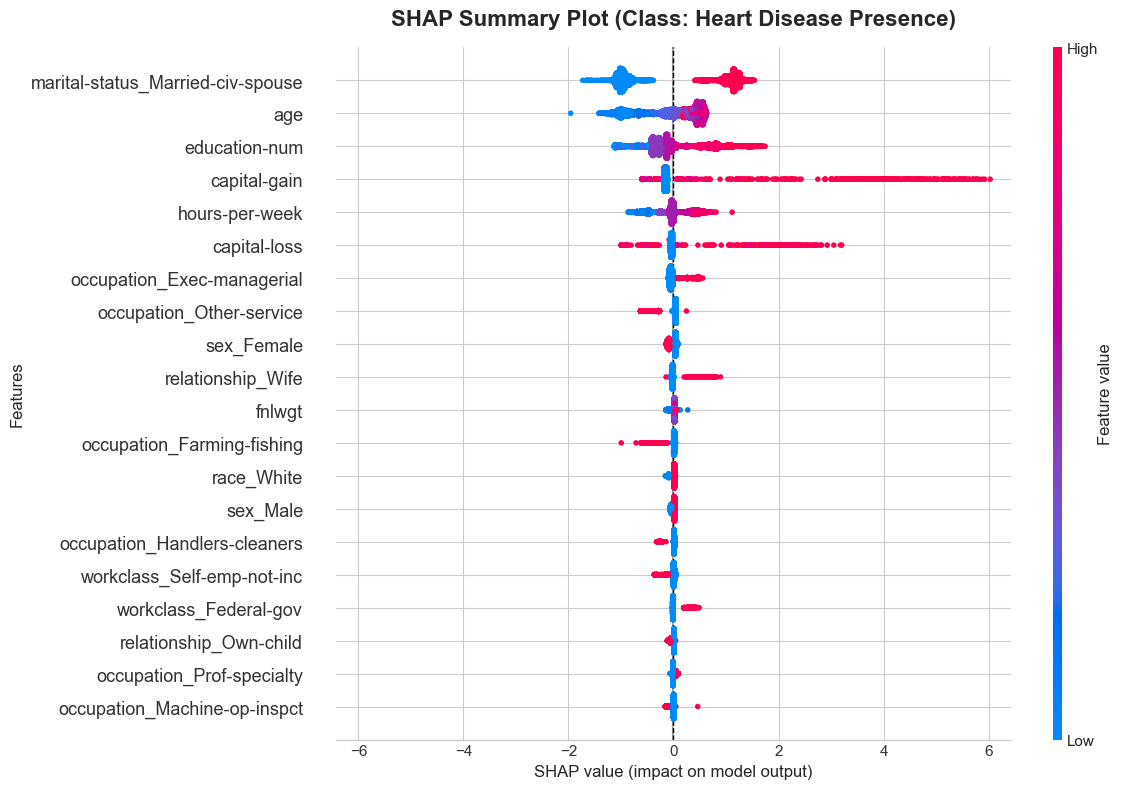

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X.columns,
    show=False,
    plot_size=(12, 8),
    color_bar=True
)

ax = plt.gca()
ax.axvline(0, color="black", linestyle="--", linewidth=1)

max_abs = np.abs(ax.get_xlim()).max()
ax.set_xlim(-max_abs, max_abs)

plt.title(
    "SHAP Summary Plot (Class: Heart Disease Presence)",
    fontsize=16,
    weight="bold",
    pad=16
)

plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.ylabel("Features", fontsize=12)

plt.tight_layout()
plt.show()


## LIME

In [11]:
#LIME setup

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["malignant", "benign"],
    discretize_continuous=True,
    mode="classification"
)

index = 0
instance = X_test.iloc[index]

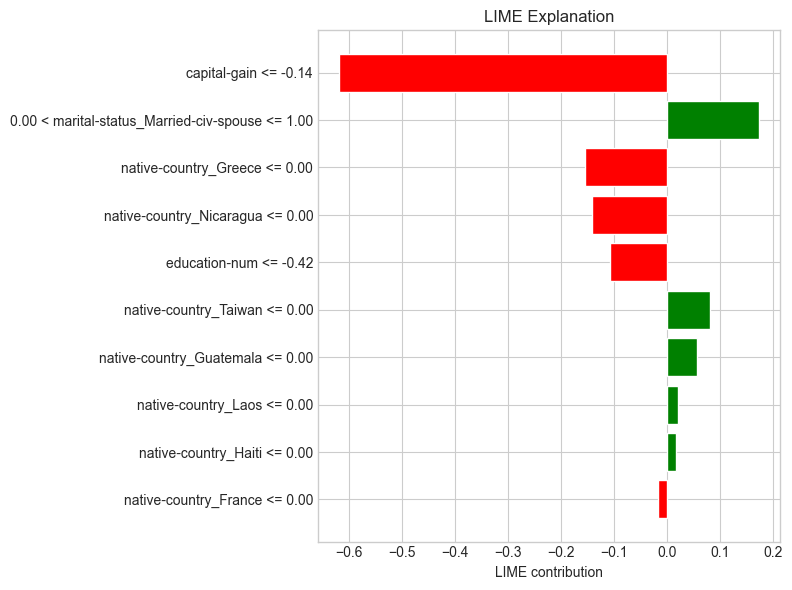

In [12]:
def predict_proba_pipeline(x):
    x_df = pd.DataFrame(x, columns=X.columns)
    return best_model.predict_proba(x_df)

lime_exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_pipeline,
    num_features=10
)

exp = lime_exp.as_list()

features = [x[0] for x in exp]
values = [x[1] for x in exp]

plt.figure(figsize=(8, 6))
colors = ["green" if v > 0 else "red" for v in values]

plt.barh(features, values, color=colors)
plt.xlabel("LIME contribution")
plt.title("LIME Explanation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

## Counterfactual Explanations (DiCE)

In [13]:
#DiCE setup

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

df = X.copy()
df["target"] = y

dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=num_features,
    categorical_features=cat_features,
    outcome_name="target"
)

dice_model = dice_ml.Model(
    model=best_model,
    backend="sklearn",
    model_type="classifier"
)

dice = Dice(
    dice_data,
    dice_model,
    method="random"
)

query_instance = X_test.iloc[[0]]

In [14]:
dice.generate_counterfactuals(
    query_instance,
    features_to_vary=[
        f for f in num_features if f != "fnlwgt"
    ],
    total_CFs=3,
    desired_class=1
)

dice_exp = dice.generate_counterfactuals(
    query_instance,
    total_CFs=3,
    desired_class=1
)

dice_exp.visualize_as_dataframe()


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Adrian\Desktop\XAI UJ\counterfactual-analysis\.venv\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:165: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_instance_df[self.data_interface.outcome_name] = \
  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Adrian\Desktop\XAI UJ\counterfactual-analysis\.venv\Lib\site-packages\dice_ml\explainer_interfaces\dice_random.py:165: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_instance_df[self.data_interface.outcome_name] = \
10

Query instance (original outcome : <=50K)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,target
0,-0.046942,-0.288677,-0.419335,-0.144804,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,<=50K



Diverse Counterfactual set (new outcome: >50K)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,target
0,-0.046942,-0.288677,-0.419335,5.271918,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,>50K
1,-0.046942,-0.288677,-0.419335,-0.144804,4.543720,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,>50K
2,-0.046942,-0.288677,-0.419335,10.269859,-0.217127,-0.034087,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,>50K


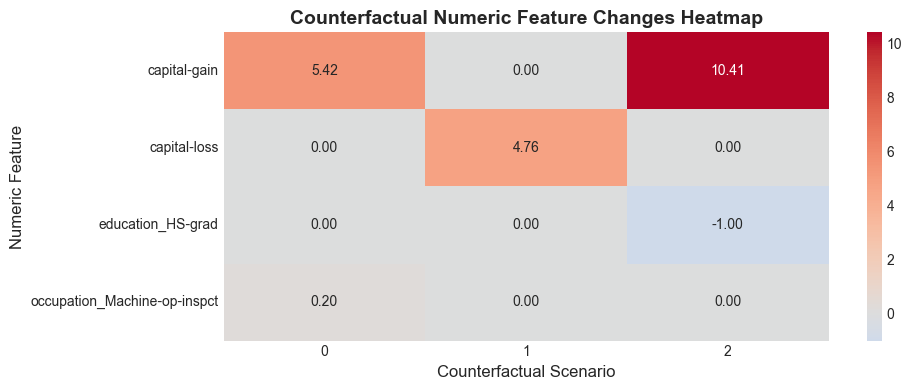

In [15]:
cf_df = dice_exp.cf_examples_list[0].final_cfs_df
original = query_instance.iloc[0]

#ONLY numeric features
numeric_cols = num_features
original_num = pd.DataFrame(
    [original[numeric_cols].values] * len(cf_df),
    columns=numeric_cols
)

diff_num = cf_df[numeric_cols] - original_num
diff_changed = diff_num.loc[:, (diff_num != 0).any(axis=0)]


plt.figure(figsize=(10, 4))
sns.heatmap(
    diff_changed.T,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)

plt.title("Counterfactual Numeric Feature Changes Heatmap", fontsize=14, weight="bold")
plt.xlabel("Counterfactual Scenario", fontsize=12)
plt.ylabel("Numeric Feature", fontsize=12)

plt.tight_layout()
plt.show()


----

## Evaluation

#### VALIDITY

In [23]:
desired_class = 0
cf_features = cf_df[X.columns]
cf_preds = best_model.predict(cf_features)
orig = query_instance.iloc[0][X.columns]
cf_X = cf_features
l1_distance = (cf_X - orig).abs().sum(axis=1)

In [28]:
clf = best_model

validity = clf.predict(cf_X) == desired_class

validity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_X))],
    "Validity": validity
})

validity_df

,Counterfactual,Validity
0,CF_0,False
1,CF_1,False
2,CF_2,False


#### SPARSITY

In [31]:
orig = query_instance.iloc[0][cf_X.columns]
sparsity = (cf_X != orig).sum(axis=1)

sparsity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(cf_X))],
    "Sparsity (number of features changed)": sparsity
})

sparsity_df


,Counterfactual,Sparsity (number of features changed)
0,CF_0,2
1,CF_1,1
2,CF_2,2


#### PROXIMITY


In [34]:
orig = query_instance.iloc[0][cf_X.columns]

orig_repeated = np.repeat(
    orig.values.reshape(1, -1),
    cf_X.shape[0],
    axis=0
)

l1_distance = np.abs(cf_X.values - orig_repeated).sum(axis=1)

proximity_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(l1_distance))],
    "Proximity (L1 distance)": l1_distance
})

proximity_df

,Counterfactual,Proximity (L1 distance)
0,CF_0,5.616722
1,CF_1,4.760847
2,CF_2,11.414662


#### PLAUSIBILITY

In [35]:
num_cols = cf_X.select_dtypes(include=["int64", "float64"]).columns
common_cols = num_cols.intersection(X.columns)

X_num = X[common_cols]

def plausible(cf_row, X_num):
    return ((cf_row >= X_num.min()) & (cf_row <= X_num.max())).all()

plausibility = cf_X[common_cols].apply(
    lambda row: plausible(row, X_num),
    axis=1
)

plausibility_df = pd.DataFrame({
    "Counterfactual": [f"CF_{i}" for i in range(len(plausibility))],
    "Plausible (within data range)": plausibility
})

plausibility_df


,Counterfactual,Plausible (within data range)
0,CF_0,True
1,CF_1,True
2,CF_2,True
